<a href="https://colab.research.google.com/github/oseledets/talks-online/blob/master/phys_ml_multiobj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physical ML from multi-objective optimization perspective

## Why multi-objective?

1. We need to train model $f(\theta|x)$ such that it solves PDE, so $\mathcal{L}_1$ is a loss to evaluate quality of solution
2. We have boundary/initial conditions that also have to be satisfied, therefore loss $\mathcal{L}_2$ comes from this requirement

In [ ]:
!pip install flax

     |████████████████████████████████| 81kB 2.2MB/s 


In [ ]:
import jax.numpy as jnp
from jax import jit, vmap
from jax import random
import jax
import numpy as np  
import matplotlib.pyplot as plt
import flax
import flax.nn as nn
from flax import optim

### Test problem 

As a test problem, we use Burgers equation.
As a test model, we consider neural network with 9 layers and hyperbolic tangent activation function after every layer and 20 neuron in every hidden layer (https://arxiv.org/pdf/1711.10561.pdf) 

In [ ]:
class MLP(nn.Module):
  """Multi Layer Perceptron."""

  def apply(self, x, t, num_layers=9):
    y = jnp.concatenate((x[None], t[None]))
    for i in range(num_layers):
        y = nn.Dense(y, 20)
        y = nn.tanh(y)
    u = nn.Dense(y, 1)
    return u

In [ ]:
Nu = 100
x_range = jnp.linspace(-1, 1, Nu)
t_range = jnp.linspace(0, 1, Nu)
u_init = -jnp.sin(jnp.pi * x_range)
u_right = jnp.zeros_like(t_range)
u_left = jnp.zeros_like(t_range)


In [ ]:
rng = random.PRNGKey(0)
rng, key = random.split(rng)
_, initial_params = MLP.init(key, x_range[0], t_range[0])
model_init = nn.Model(MLP, initial_params)
model_init_batch = jax.jit(jax.vmap(model_init, [0, 0]))

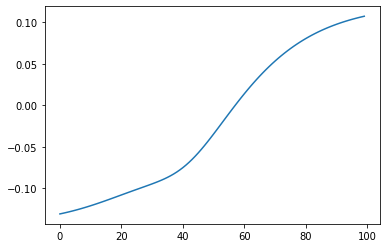

In [ ]:
plt.plot(model_init_batch(x_range, t_range))

In [ ]:
Nf = 100
x_range = jnp.linspace(-1, 1, Nu)
t_range = jnp.linspace(0, 1, Nu)
X, T = jnp.meshgrid(x_range, t_range)
x_coloc = X.flatten()
t_coloc = T.flatten()



In [ ]:
def pde_res_0(model, x, t):
    u = model(x, t)
    u_t = jax.jacobian(model, 1)(x, t)
    u_x = jax.jacobian(model, 0)(x, t)
    u_xx = jax.hessian(model, 0)(x, t)
    res = u_t + u * u_x - (0.01/jnp.pi)*u_xx
    return res

pde_res_0 = jax.jit(pde_res_0) #Now this thing is fast
pde_res = jax.jit(jax.vmap(pde_res_0, [None, 0, 0]))


def pde_bc_0(model, t, u_left, u_right):
    u_left_pred = model(jnp.array(-1.0), t)
    u_right_pred = model(jnp.array(1.0), t)
    return (u_left_pred - u_left)**2 + (u_right_pred-u_right)**2

def pde_init_0(model, x, u_init):
    u_init_pred = model(x, jnp.array(0.0))
    return (u_init_pred - u_init)**2

pde_bc = jax.jit(jax.vmap(pde_bc_0, [None, 0, 0, 0]))
pde_init = jax.jit(jax.vmap(pde_init_0, [None, 0, 0]))


#Now we can define losses

@jax.jit
def loss_pde(model, x, t):
    pred = pde_res(model, x, t)
    return jnp.mean(jnp.square(pred))

@jax.jit
def loss_bc(model, t, u_left, u_right):
    pred = pde_bc(model, t, u_left, u_right)
    return jnp.mean(pred)

@jax.jit
def loss_init(model, x, u_init):
    pred = pde_init(model, x, u_init)
    return jnp.mean(pred)

@jax.jit
def loss_baseline(model, xc, tc, x, t, u_left, u_right, u_init):
    return loss_pde(model, xc, tc) + loss_bc(model, t, u_left, u_right) + loss_init(model, x, u_init)

@jax.jit
def loss_init_bc(model, x, u_init, t, u_left, u_right):
    pred_init = pde_init(model, x, u_init)
    pred_bc = pde_bc(model, t, u_left, u_right)
    return jnp.mean(pred_init) + jnp.mean(pred_bc)

In [ ]:
#print(loss_f(model, x_coloc, t_coloc), loss_bc(model, t_range, u_left, u_right), 
#    loss_init(model, x_range, u_init))

In [ ]:
lr = 1e-2
num_epoch = 1000
checkpoint_adam_model_epoch = 10

In [ ]:
model_adam = nn.Model(MLP, model_init.params)

optimizer_def = optim.Adam(learning_rate=lr)
optimizer = optimizer_def.create(model_adam)

@jax.jit
def update_init(optimizer):
    loss_init_val, grad_init = jax.value_and_grad(loss_init)(optimizer.target, x_range, u_init)
    return optimizer.apply_gradient(grad_init)

@jax.jit
def update_baseline(optimizer):
    loss, grad = jax.value_and_grad(loss_baseline)(optimizer.target, x_coloc, t_coloc, \
                                                   x_range, t_range, u_left, \
                                                   u_right, u_init)
    return optimizer.apply_gradient(grad)


In [ ]:
loss_adam_conv = {
    "Init": [],
    "BC": [],
    "PDE": []
}
for epoch_idx in range(num_epoch):
    if epoch_idx == checkpoint_adam_model_epoch:
        checkpoint_adam_model = optimizer.target
    # optimizer = update_baseline(optimizer)
    optimizer = update_init(optimizer)
    loss_adam_conv["Init"].append(loss_init(optimizer.target, x_range, u_init))
    loss_adam_conv["BC"].append(loss_bc(optimizer.target, t_range, u_left, u_right))
    loss_adam_conv["PDE"].append(loss_pde(optimizer.target, x_coloc, t_coloc))

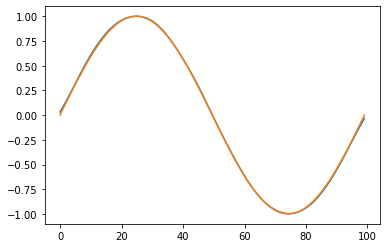

In [ ]:
plt.plot(jax.vmap(optimizer.target, [0, 0])(x_range, 0 * x_range))
plt.plot(u_init)

## EDM approach

In [ ]:
import copy
# model_start = optimizer.target

In [ ]:
loss_list_optimize = {
            "BC": loss_bc,
            "Init": loss_init,
            "PDE": loss_pde,
            # "Init + BC": loss_init_bc
            }

args_optimize = {
    "BC": [t_range, u_left, u_right],
    "Init": [x_range, u_init],
    "PDE": [x_coloc, t_coloc],
    # "Init + BC": [x_range, u_init, t_range, u_left, u_right]
}

In [ ]:
import numpy as onp
from jax import lax
from jax import flatten_util

max_iter_fw = 300
tol_fw = 1e-6
lr_edm_max = 1e-2

@jax.jit
def make_edm_step(model):
    current_params, unravel_func = flatten_util.ravel_pytree(model)
    num_params = current_params.shape[0]
    num_losses = len(loss_list_optimize)
    grads = jnp.zeros((num_params, num_losses))
    loss_vals = jnp.zeros(len(loss_list_optimize))
    for i, loss_name in enumerate(loss_list_optimize):
        cur_loss, cur_grad = jax.value_and_grad(loss_list_optimize[loss_name])(model, *args_optimize[loss_name])
        vec_cur_grad, _ = flatten_util.ravel_pytree(cur_grad)
        grads = jax.ops.index_update(grads, jax.ops.index[:, i], vec_cur_grad)
        loss_vals = jax.ops.index_update(loss_vals, jax.ops.index[i], cur_loss)
        # grads[:, i] = vec_cur_grad
    if num_losses > 2:
        db, alpha = get_edm_direction(grads)
    elif num_losses == 2:
        norm_grads = jnp.linalg.norm(grads, axis=0)
        # print(norm_grads)
        db = ((grads[:, 0] * norm_grads[1]) + (grads[:, 1] * norm_grads[0])) / jnp.sum(norm_grads)
    # print(db)
    lr_edm = jnp.minimum((loss_vals @ alpha) / jnp.linalg.norm(db), lr_edm_max)
    new_params = current_params - lr_edm * db
    new_model = unravel_func(new_params)
    return new_model

@jax.jit
def get_edm_direction(grads):
    norm_grads = jnp.linalg.norm(grads, axis=0)
    # print(norm_grads)
    normed_grads = grads / norm_grads
    num_grads = grads.shape[1]
    M = normed_grads.T @ normed_grads 
    alpha = jnp.ones(num_grads) / num_grads
    for i in range(max_iter_fw):
        alpha_M = M @ alpha
        t = jnp.argmin(alpha_M)
        gamma = get_stepsize(alpha, t, M)
        alpha = (1 - gamma) * alpha

        alpha = jax.ops.index_add(alpha, jax.ops.index[t], gamma)
        # alpha[t] += gamma
        # if gamma < tol_fw:
        #     break
    d_p = normed_grads @ alpha
    scale_factor = jnp.sum(alpha / norm_grads)
    alpha = alpha / scale_factor
    return normed_grads @ alpha, alpha

@jax.jit
def get_stepsize(alpha, t, M):
    diff = alpha
    diff = jax.ops.index_add(diff, jax.ops.index[t], -1)
    # diff[t] -= 1
    gamma = (diff @ M @ alpha) / (diff @ M @ diff)
    return jnp.maximum(jnp.minimum(gamma, 1), 0)
    # cross_inner_prod = M[t, :] @ alpha


    # if cross_inner_prod >= M[t, t]:
    #     gamma = 1
    # elif cross_inner_prod >= alpha @ M @ alpha:
    #     gamma = 0
    # else:
    #     diff = alpha.copy()
    #     diff = jax.ops.index_add(diff, jax.ops.index[t], -1)
    #     # diff[t] -= 1
    #     gamma = (diff @ M @ alpha) / (diff @ M @ diff)
    # return gamma

In [ ]:
loss_list_log = {
    "BC": loss_bc, 
    "Init": loss_init,
    "PDE": loss_pde
    }
args_log = {
    "BC": [t_range, u_left, u_right], 
    "Init": [x_range, u_init],
    "PDE": [x_coloc, t_coloc]
    }
#loss_list = {"init": loss_init}
#args = {"init": [x_range, u_init]}
# loss_list = {"BC": loss_bc, "init": loss_init, "pde": loss_pde}
# args = {"BC": [t_range, u_left, u_right], "init": [x_range, u_init], "pde": [x_coloc, t_coloc]}

loss_all_conv = {loss_name: [] for loss_name in loss_list_log}
model_edm = nn.Model(MLP, model_init.params)
# model_edm = nn.Model(MLP, checkpoint_adam_model.params)
model_edm = nn.Model(MLP, optimizer.target.params)
for loss_name in loss_list_log:
    loss_all_conv[loss_name].append(loss_list_log[loss_name](model_edm, *args_log[loss_name]))
for _ in range(num_epoch):
    model_edm = make_edm_step(model_edm)
    # print(model_edm)
    for loss_name in loss_list_log:
        loss_all_conv[loss_name].append(loss_list_log[loss_name](model_edm, *args_log[loss_name]))

In [ ]:
# loss_all_conv['BC'][-1], loss_all_conv['init'][-1]

In [ ]:
# loss_all_conv['init'][-1], loss_all_conv['BC'][-1], loss_all_conv['pde'][-1]

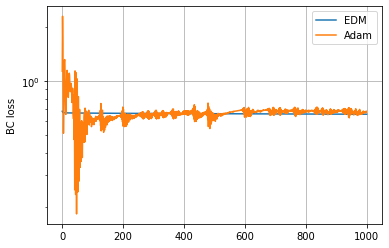

In [ ]:
plt.plot(loss_all_conv["BC"], label="EDM")
plt.plot(loss_adam_conv["BC"], label="Adam")
plt.ylabel("BC loss")
plt.legend()
plt.yscale("log")
plt.grid(True)

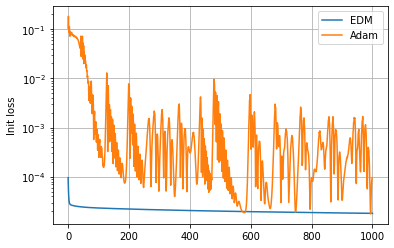

In [ ]:
plt.plot(loss_all_conv["Init"], label="EDM")
plt.plot(loss_adam_conv["Init"], label="Adam")
plt.ylabel("Init loss")
plt.legend()
plt.grid(True)
plt.yscale("log")

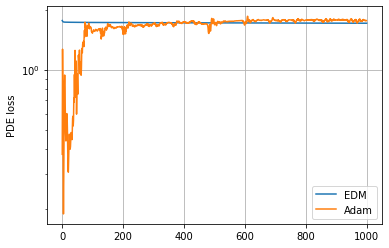

In [ ]:
plt.plot(loss_all_conv["PDE"], label="EDM")
plt.plot(loss_adam_conv["PDE"], label="Adam")
plt.ylabel("PDE loss")
plt.legend()
plt.yscale("log")
plt.grid(True)

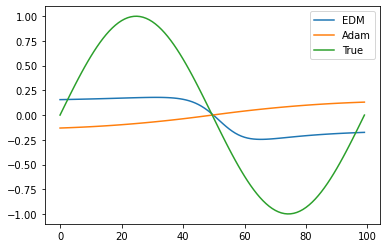

In [ ]:
plt.plot(jax.vmap(model_edm, [0, 0])(x_range, 0 * x_range),label="EDM")
plt.plot(jax.vmap(model_adam, [0, 0])(x_range, 0 * x_range),label="Adam")
plt.plot(u_init, label="True")
plt.legend()